In [1]:
import numpy as np
import numpy.linalg as la
import scipy.sparse as sps
import scipy.sparse.linalg as spsla
import matplotlib.pyplot as plt
import sys, time
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
import problems, projection, optimize, util

# 1D problem testing
1. generate blur problem ($K, X, s_b, s_x, M$)
2. compute $R = (X^T X + \lambda I)^{-1}$ directly
3. solve $MRK R^T M^T w = MR s_b$ for $w_d$ directly
4. solve ESI system for $u_m$ with MINRES (gold-standard)
> - check template equation
    1. compute $w_m = M(X^T X + \lambda I) u_m$
    2. compute $r_m = MRK R^T M^T w_m - MR s_b$
> - check MINRES template vs direct template
    3. plot $w_m$ vs $w_d$
    4. compute $\|w_m - w_d\|^2$
5. run POCS on $P_1$: $\min_u \|K^{1/2}Xu - K^{-1/2}s_b\|$ and $P_2$: $(I-M^T M)(X^T X + \lambda I)u = 0$ for $u_p$
> - check template equation
    1. compute $w_p = M(X^T X + \lambda I) u_p$
    2. compute $r_p = MRK R^T M^T w_m - MR s_b$
> - check POCS template vs direct template
    3. plot $w_p$ vs $w_d$
    4. compute $\|w_p - w_d\|^2$
6. run DR on $P_1$: $\min_u \|K^{1/2}Xu - K^{-1/2}s_b\|$ and $P_2$: $(I-M^T M)(X^T X + \lambda I)u = 0$ for $u_{dr}$
> - check template equation
    1. compute $w_{dr} = M(X^T X + \lambda I) u_{dr}$
    2. compute $r_{dr} = MRK R^T M^T w_m - MR s_b$
> - check POCS template vs direct template
    3. plot $w_{dr}$ vs $w_d$
    4. compute $\|w_{dr} - w_d\|^2$
7. run RAAR on $P_1$: $\min_u \|K^{1/2}Xu - K^{-1/2}s_b\|$ and $P_2$: $(I-M^T M)(X^T X + \lambda I)u = 0$ for $u_{r}$
> - check template equation
    1. compute $w_{r} = M(X^T X + \lambda I) u_{r}$
    2. compute $r_{r} = MRK R^T M^T w_m - MR s_b$
> - check POCS template vs direct template
    3. plot $w_{r}$ vs $w_d$
    4. compute $\|w_{r} - w_d\|^2$

1. generate blur problem ($K, X, s_b, s_x, M$)
---
---

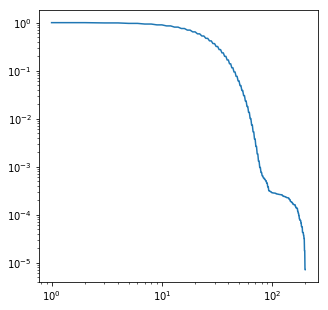

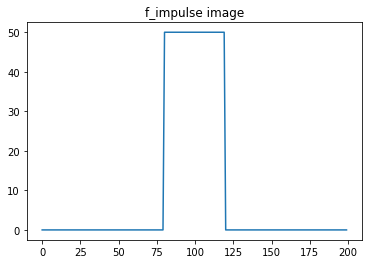

=================== setup ====================
(n_1, n_2, m) = (200, None, 200)
problem       = 1D Blur
lam           = 10.0
B             = <class 'scipy.sparse.dia.dia_matrix'>
ROI pixels    = 60
ROI row       = 100

================== contents ==================
K_diag        = [ 1.  1.  1.  1.  1.]...[ 1.  1.  1.  1.  1.]
sigma         = 3
t             = 10
ESI?          = True
ESIN?         = True
ESI3?         = True
direct?       = True
================= dimensions ==================
Kb shape      = (200, 200)
X shape       = (200, 200)
M shape       = (60, 200)
B shape       = (200, 200)
sx shape      = (200, 1)
sb shape      = (200, 1)
============= system dimensions ===============
ESI_A shape   = (400, 400)
ESI_b shape   = (400,)
ESIN_A shape  = (400, 400)
ESIN_b shape  = (400,)
ESI3_A shape  = (600, 600)
ESI3_b shape  = (600,)


/Users/jakeroth/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


In [3]:
# dims
n_1   = 200    # image
k     = 60     # roi (signal is 50 pixels wide)

# blur
sigma = 3
t     = 10

# optimization
tol   = 1e-5   # tolerance
niter = 100    # max number of iterations
dr_sl = 1.5    # dr step length
beta  = 0.25   # wtd avg for RAAR

# get max singular value of XtX
tp = problems.Problem(prob='b', n_1=n_1, k=k, ESI=False, ESIN=False, ESI3=False, dir_soln=False)
tp._set_inputs(K_diag=np.ones(tp.n), sigma=sigma, t=t, sparse=True)
tp._set_operators()

Xa  = tp.X.toarray()  # X (as array)
XtX = Xa.T.dot(Xa)
_, s, _ = la.svd(Xa)
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))
plt.subplot(1,1,1)
plt.loglog(s)
plt.show()

# regularization
msv   = s[0]
lam   = 10*msv

# problem
p = problems.Problem(prob='b', n_1=n_1, k=k, lam=lam, ESI=True, ESIN=True, ESI3=True, dir_soln=True)
p.create_problem(K_diag=np.ones(p.n), sigma=sigma, t=t, sparse=True, plot=True)
p.summarize()

2. compute $R = (X^T X + \lambda I)^{-1}$ directly
---
---

In [4]:
R_d = util.direct_rxn(X=p.X, lam=p.lam, B=None, sparse=True)
R_d_check = spsla.inv(p.X.T.dot(p.X) + p.lam * sps.eye(p.n))
sum(sum(R_d.toarray() - R_d_check.toarray()))

-1.8837799357648871e-15

3. solve $MRK R^T M^T w = MR s_b$ for $w_d$ directly
---
---

In [5]:
w_d,_,_ = util.direct_solve(Kb=p.Kb, R=R_d, M=p.M, B=None, sb=p.sb, sparse=True)
w_d_check = spsla.inv(p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T)).dot(p.M.dot(R_d).dot(p.sb))
w_d_check_check = spsla.spsolve(p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T), p.M.dot(R_d).dot(p.sb)).reshape(p.k,1)
print(sum(sum(w_d - w_d_check)))
print(sum(sum(w_d - w_d_check_check)))

-0.000117706844539
0.0


/Users/jakeroth/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/jakeroth/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:171: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


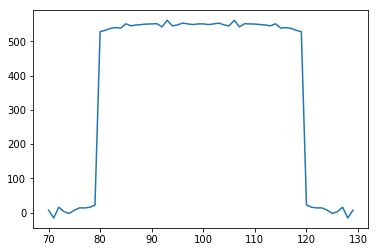

In [6]:
px_idx = [(p.n-p.k)/2 + i for i in range(p.k)]
plt.plot(px_idx, w_d)
plt.show()

4. solve ESI system for $u_m$ with MINRES (gold-standard)
---
> - check template equation
    1. compute $w_m = M(X^T X + \lambda I) u_m$
    2. compute $r_m = MRK R^T M^T w_m - MR s_b$
> - check MINRES template vs direct template
    3. plot $w_m$ vs $w_d$
    4. compute $\|w_m - w_d\|^2$

---

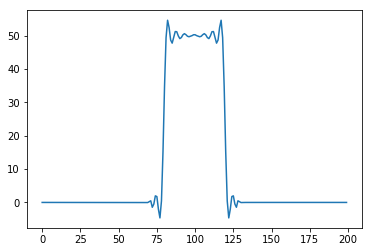

In [7]:
# solve for u
u_m, _, us_m, mr_m, t_m, tt_m = spsla.minres_track(A=p.ESI_A, b=p.ESI_b, tol=tol, maxiter=niter)
plt.plot(u_m[0:p.n])
plt.show()

In [8]:
# compute template w
w_m = util.calc_hot(X=p.X, B=None, lam=p.lam, M=p.M, u=u_m, ESI=True)
w_m_check = p.M.dot(p.X.T.dot(p.X) + p.lam*sps.eye(p.n)).dot(u_m[0:p.n]).reshape(p.k,1)
sum(w_m - w_m_check)

array([ 0.])

In [9]:
# compute template residuals
r_m = p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T).dot(w_m) - p.M.dot(R_d).dot(p.sb)
_r_m_ = la.norm(r_m)
print(_r_m_)

2.81011723032e-06


In [10]:
# compute template errors
e_m = w_m - w_d
print('norm hotelling template error: %s' % round(la.norm(w_m - w_d),3))

norm hotelling template error: 335.387


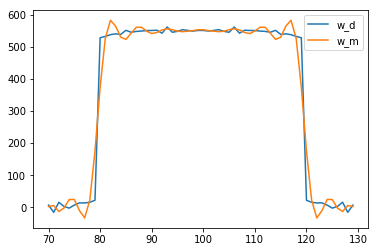

In [11]:
# plot w
px_idx = [(p.n-p.k)/2 + i for i in range(p.k)]
plt.plot(px_idx, w_d)
plt.plot(px_idx, w_m)
plt.legend(['w_d','w_m'])
plt.show()

5. run POCS on $P_1$: $\min_u \|K^{1/2}Xu - K^{-1/2}s_b\|$ and $P_2$: $(I-M^T M)(X^T X + \lambda I)u = 0$ for $u_p$
---
---

----- POCS -----------------------
(0.0, 'pocs constr 0')
(4196.0661446076901, 'pocs resid 0')
----- POCS -----------------------
    pocs runtime: 0.948


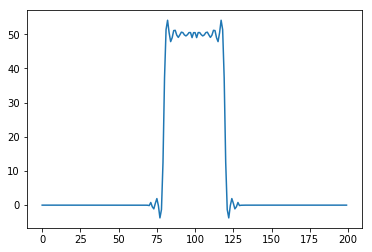

In [12]:
# solve for u
u_p, mr_p, cr_p, t_p, us_p, hr_p, tt_p = projection.pocs(
            p.Kb, p.X, p.sb, p.lam, p.M, max_iter=niter, tol=tol, full_output=1, R=R_d
)
plt.plot(u_p[0:p.n])
plt.show()

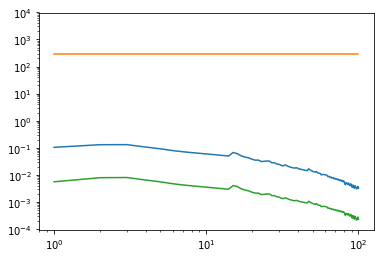

In [13]:
plt.loglog(mr_p)
plt.loglog(cr_p)
plt.loglog(hr_p)
plt.show()

In [14]:
# compute template w
w_p = util.calc_hot(X=p.X, B=None, lam=p.lam, M=p.M, u=u_p)
w_p_check = p.M.dot(p.X.T.dot(p.X) + p.lam*sps.eye(p.n)).dot(u_p).reshape(p.k,1)
sum(w_p - w_p_check)

array([ 0.])

In [15]:
# compute template residuals
r_p = p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T).dot(w_p) - p.M.dot(R_d).dot(p.sb)
_r_p_ = la.norm(r_p)
print(_r_p_)

0.000237979303366


In [16]:
# compute template errors
e_p = w_p - w_d
print('norm hotelling template error: %s' % round(la.norm(e_p),3))

norm hotelling template error: 277.878


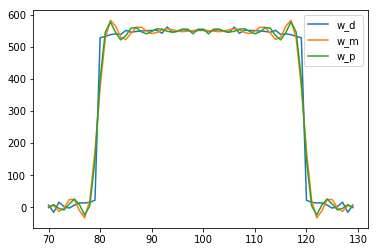

In [17]:
# plot w
px_idx = [(p.n-p.k)/2 + i for i in range(p.k)]
plt.plot(px_idx, w_d)
plt.plot(px_idx, w_m)
plt.plot(px_idx, w_p)
plt.legend(['w_d','w_m','w_p'])
plt.show()

6. run DR on $P_1$: $\min_u \|K^{1/2}Xu - K^{-1/2}s_b\|$ and $P_2$: $(I-M^T M)(X^T X + \lambda I)u = 0$ for $u_{dr}$
---
---

----- DR -------------------------
(0.0, 'dr constr 0')
(4196.0661446076901, 'dr min 0')
----- DR -------------------------
    dr runtime: 1.075


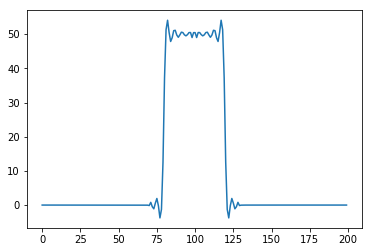

In [18]:
# solve for u
u_dr, mr_dr, cr_dr, _, t_dr, us_dr, hr_dr, tt_dr = projection.dr(
            p.Kb, p.X, p.sb, p.lam, p.M, max_iter=niter, tol=tol, full_output=1, R=R_d, sl=dr_sl
)
plt.plot(u_dr[0:p.n])
plt.show()

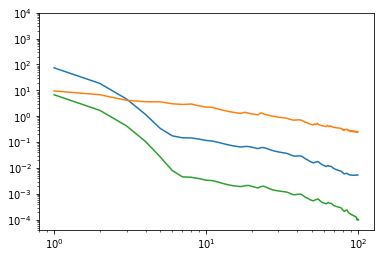

In [19]:
plt.loglog(mr_dr)
plt.loglog(cr_dr)
plt.loglog(hr_dr)
plt.show()

In [20]:
# compute template w
w_dr = util.calc_hot(X=p.X, B=None, lam=p.lam, M=p.M, u=u_dr)
w_dr_check = p.M.dot(p.X.T.dot(p.X) + p.lam*sps.eye(p.n)).dot(u_dr).reshape(p.k,1)
sum(w_dr - w_dr_check)

array([ 0.])

In [21]:
# compute template residuals
r_dr = p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T).dot(w_dr) - p.M.dot(R_d).dot(p.sb)
_r_dr_ = la.norm(r_dr)
print(_r_dr_)

0.00010625993211


In [22]:
# compute template errors
e_dr = w_dr - w_d
print('norm hotelling template error: %s' % round(la.norm(e_dr),3))

norm hotelling template error: 278.328


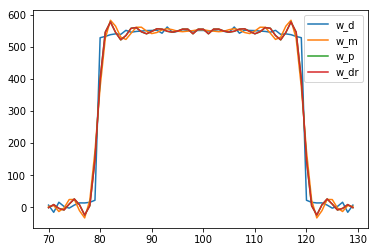

In [23]:
# plot w
px_idx = [(p.n-p.k)/2 + i for i in range(p.k)]
plt.plot(px_idx, w_d)
plt.plot(px_idx, w_m)
plt.plot(px_idx, w_p)
plt.plot(px_idx, w_dr)
plt.legend(['w_d','w_m','w_p','w_dr'])
plt.show()

7. run RAAR on $P_1$: $\min_u \|K^{1/2}Xu - K^{-1/2}s_b\|$ and $P_2$: $(I-M^T M)(X^T X + \lambda I)u = 0$ for $u_{r}$
---
---

----- RAAR -----------------------
(0.0, 'raar constr 0')
(4196.0661446076901, 'raar resid 0')
----- RAAR -----------------------
    raar runtime: 0.977


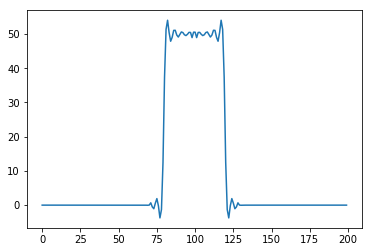

In [24]:
# solve for u
u_r, mr_r, cr_r, t_r, us_r, hr_r, tt_r = projection.raar(
            p.Kb, p.X, p.sb, p.lam, p.M, beta=beta, max_iter=niter, tol=tol, full_output=1, R=R_d
        )
plt.plot(u_r[0:p.n])
plt.show()

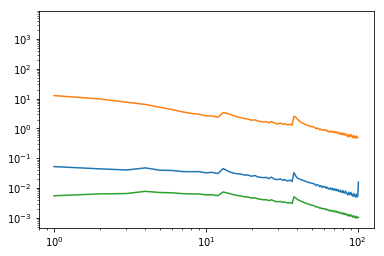

In [25]:
plt.loglog(mr_r)
plt.loglog(cr_r)
plt.loglog(hr_r)
plt.show()

In [26]:
# compute template w
w_r = util.calc_hot(X=p.X, B=None, lam=p.lam, M=p.M, u=u_r)
w_r_check = p.M.dot(p.X.T.dot(p.X) + p.lam*sps.eye(p.n)).dot(u_r).reshape(p.k,1)
sum(w_r - w_r_check)

60


array([ 0.])

In [27]:
# compute template residuals
r_r = p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T).dot(w_r) - p.M.dot(R_d).dot(p.sb)
_r_r_ = la.norm(r_r)
print(_r_r_)

0.00104856936514


In [28]:
# compute template errors
e_r = w_r - w_d
print('norm hotelling template error: %s' % round(la.norm(e_r),3))

norm hotelling template error: 275.761


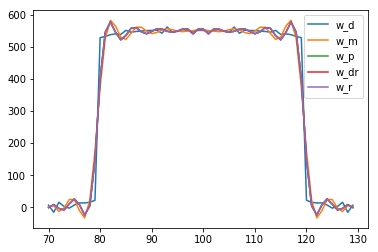

In [29]:
# plot w
px_idx = [(p.n-p.k)/2 + i for i in range(p.k)]
plt.plot(px_idx, w_d)
plt.plot(px_idx, w_m)
plt.plot(px_idx, w_p)
plt.plot(px_idx, w_dr)
plt.plot(px_idx, w_r)
plt.legend(['w_d','w_m','w_p','w_dr','w_r'])
plt.show()